In [3]:
import pandas as pd
import numpy as np
import os
from mygene import MyGeneInfo
from concurrent.futures import ThreadPoolExecutor
from pyensembl import EnsemblRelease
from sklearn.metrics import accuracy_score
import time
import pickle
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

AUGMENTATION = 80

# Specify the path to the parent directory containing the folders to iterate through
# data_geo_file_path = f"data_geo_{CANCER_TYPE}_{AUGMENTATION}.pkl"
all_data_columns_file_path = "./all_data_columns.pkl"
encoder_file = f"./encoder_{AUGMENTATION}.pkl"
model_file_name = f"xgboost-{AUGMENTATION}.model"

In [4]:
# load GEO data from pickle file
all_labels_file_path = "all_labels_geo.pkl"
all_data_file_path = "all_data_geo.pkl"

with open(all_labels_file_path, 'rb') as f:
    all_labels_geo = pickle.load(f)

with open(all_data_file_path, 'rb') as f:
    all_data_geo = pickle.load(f)

In [5]:
# load label encoder from pickle file
with open(encoder_file, 'rb') as f:
    label_encoder = pickle.load(f)
class_list = label_encoder.classes_
print(class_list)

all_data_geo["index"] = range(all_data_geo.shape[0])
all_data_geo.set_index("index", inplace=True)

all_labels_geo["index"] = range(all_labels_geo.shape[0])
all_labels_geo.set_index("index", inplace=True)

# remove the labels which model was not trained on
print(all_labels_geo["Tissue"].index.value_counts())
to_keep = all_labels_geo["Tissue"].map(lambda x: x in class_list)

labels_geo = all_labels_geo.loc[to_keep]
tpm_geo = all_data_geo.loc[to_keep]

# Get the count of samples for each unique label
label_counts = labels_geo["Tissue"].value_counts()

# Print the count of samples for each unique label
print("Label counts:")
print(label_counts)

print(labels_geo)
print(tpm_geo)

print(f'Total geo columns: {len(tpm_geo.columns)}')
print(f'Unique geo columns: {len(set(tpm_geo.columns))}')

# merging the columns with the same symbol name
data_geo = tpm_geo.groupby(tpm_geo.columns, axis=1).sum()
print(f'Total geo columns: {len(data_geo.columns)}')

unique_columns = len(set(data_geo.columns))
print(f'Unique geo columns: {unique_columns}')

['bladder' 'brain' 'breast' 'colon' 'kidney' 'liver' 'lung' 'pancreas'
 'prostate' 'skin']
index
0       1
1409    1
1407    1
1406    1
1405    1
       ..
694     1
693     1
692     1
691     1
2097    1
Name: count, Length: 2098, dtype: int64
Label counts:
Tissue
colon       285
liver       269
breast      235
kidney      224
brain       214
skin        210
pancreas    197
lung        187
prostate    140
bladder     137
Name: count, dtype: int64
        Tissue
index         
0      bladder
1      bladder
2      bladder
3      bladder
4      bladder
...        ...
2093     liver
2094     liver
2095     liver
2096     liver
2097     liver

[2098 rows x 1 columns]
Symbol  DDX11L1  WASH7P  MIR6859-1  MIR1302-2HG  MIR1302-2  FAM138A  OR4F5   
index                                                                        
0        0.9121   26.29     18.470       0.0000     0.0000  0.04445    0.0  \
1        3.5450   85.32     47.940       0.2054     0.4004  0.04889    0.0   
2        0.493

In [6]:
#open the list of genes from tcga
with open(all_data_columns_file_path, 'rb') as all_data_columns_pckl:
    all_data_columns = pickle.load(all_data_columns_pckl)

In [7]:
print("length data_geo.columns: ", len(data_geo.columns))
print("length all_data_columns: ", len(all_data_columns))

# Delete all columns from data_geo dataframe that are not present in all_data_columns list
columns_to_drop = [col for col in data_geo.columns if col not in all_data_columns]
print("length columns_to_drop: ", len(columns_to_drop))

data_geo_filtered = data_geo.drop(columns=columns_to_drop)
print("data_geo_filtered shape: " , data_geo_filtered.shape)
      
# For each column name in all_data_columns list add a column of zeros to data_geo_filtered dataframe 
# if the column with that name does not exist, otherwise ignore it

# Create a DataFrame with zeros for missing columns
zeros_df = pd.DataFrame(0, index=data_geo_filtered.index, columns=all_data_columns)

# Concatenate data_geo_filtered and zeros_df
data_geo_filtered = pd.concat([data_geo_filtered, zeros_df], axis=1)

# Remove duplicate columns
data_geo_filtered = data_geo_filtered.loc[:, ~data_geo_filtered.columns.duplicated()]


# Construct validation dataset with proper column ordering defined in all_data_columns
data_geo_test = data_geo_filtered[all_data_columns]
print("data_geo_test shape: ", data_geo_test.shape)

length data_geo.columns:  39374
length all_data_columns:  59427
length columns_to_drop:  12302
data_geo_filtered shape:  (2098, 27072)
data_geo_test shape:  (2098, 59427)


# Validate data geo on trained tcga classifier

In [8]:
# load the xgboost model
with open(model_file_name, 'rb') as f:
    model = pickle.load(f)

In [9]:
# encoding the test data with the same label encoder used in training
all_labels_encoded = label_encoder.transform(np.ravel(labels_geo))

print(all_labels_encoded)

# sort the data_geo_test columns
data_geo_test = data_geo_test[sorted(data_geo_test.columns)]

[0 0 0 ... 5 5 5]


Verifying accuracy...
Accuracy of the test: 83.9371%
['bladder' 'brain' 'breast' 'colon' 'kidney' 'liver' 'lung' 'pancreas'
 'prostate' 'skin']
[[109   0   1   3   0   0  11   0   2  11]
 [  1 171   5   0   4   1   2  21   0   9]
 [  0   0 235   0   0   0   0   0   0   0]
 [  9   1   4 239   3   0   8   8   1  12]
 [ 18   0   8   9 126   3  25   0   0  35]
 [  3   0   2   0   1 243   5   6   0   9]
 [  0   3  11   1   4   0 158   5   0   5]
 [  2   0   2   4   0   0   4 185   0   0]
 [  0   0   1   0   0   0   1   0 138   0]
 [  5   0  32   7   3   0   6   0   0 157]]


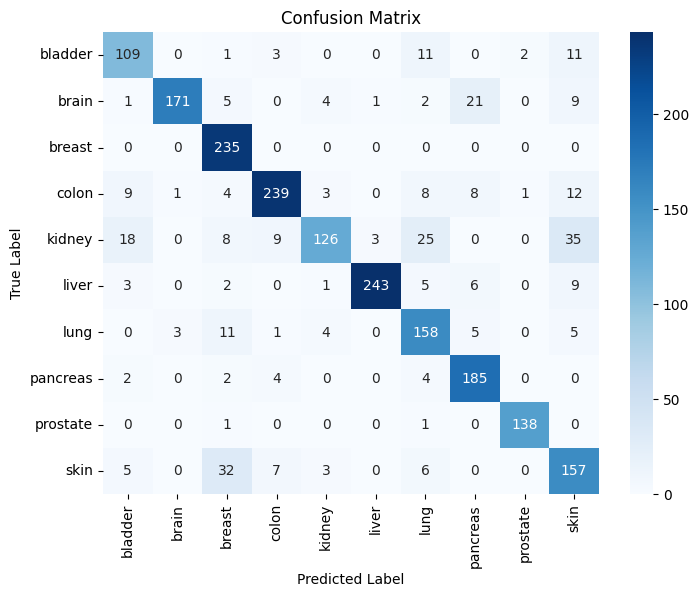

In [10]:
print("Verifying accuracy...")
# verify accuracy of the test data
pred_test = model.predict(data_geo_test)

accuracy = sum(pred_test == all_labels_encoded) / float(len(pred_test))

print("Accuracy of the test: %.4f%%" % (accuracy * 100.0))

print(label_encoder.classes_)
confusion = sklearn.metrics.confusion_matrix(all_labels_encoded, pred_test)
print(confusion)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already calculated the confusion matrix
confusion = confusion_matrix(all_labels_encoded, pred_test)

# Calculate precision
precision = precision_score(all_labels_encoded, pred_test, average='macro')

# Calculate recall
recall = recall_score(all_labels_encoded, pred_test, average='macro')

# Calculate F1 score
f1 = f1_score(all_labels_encoded, pred_test, average='macro')

# Print the results
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))


Precision: 0.8464
Recall: 0.8416
F1 Score: 0.8364


In [29]:
print("Verifying accuracy for each cancer type...")
# verify accuracy of the test data

pred_test = model.predict(data_geo_test)

accuracy = sum(pred_test == all_labels_encoded) / float(len(pred_test))

for i in range(len(class_list)):
    idx = all_labels_encoded == i
    pred_test_class = pred_test[idx]
    all_labels_class = all_labels_encoded[idx]

    accuracy_class = sum(pred_test_class == all_labels_class) / float(len(pred_test_class))
    print(f'Accuracy of class {class_list[i]}: \t{accuracy_class*100:.2f}%')

Verifying accuracy for each cancer type...
Accuracy of class bladder: 	79.56%
Accuracy of class brain: 	79.91%
Accuracy of class breast: 	100.00%
Accuracy of class colon: 	83.86%
Accuracy of class kidney: 	56.25%
Accuracy of class liver: 	90.33%
Accuracy of class lung: 	84.49%
Accuracy of class pancreas: 	93.91%
Accuracy of class prostate: 	98.57%
Accuracy of class skin: 	74.76%
